# Spectral Envelope Smoothing and Energy Correlation Screening
This notebook presents code for reproducing an undergraduate research project focused on creating a new Change Detection (CD) technique satellite image time series. In this case study, Synthetic Aperture Radar (SAR) data is utilized, collected from Sentinel-1 through the Google Earth Engine Python API.

**WARNING**: If the data is already available (`testing/raster_*.tif` and `testing/optimal_*.tif` files), skip to the Energy Correlation Screening section in this notebook.

## Imports
These are the necessary packages for reproducing this code. Install from `environment.yml`.

In [1]:
import ee
import geemap
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sn
import time
import os
import re
from skimage.filters import try_all_threshold, threshold_otsu, threshold_yen, threshold_triangle, threshold_li
from skimage.restoration import denoise_tv_chambolle
from pkg import pkg
from pkg import save
from osgeo import gdal
import rasterio
from rasterio.mask import mask
import geopandas as gpd
import spenv

## Data extraction
In this study, GEE data is collected programatically. This step in the notebook is somewhat computationally heavy and can be skipped if the necessary data is already available.

### Using GEE 
The area of interest is used to filter and crop the satellite image time series in GEE as shown below.

In [35]:
ee.Authenticate()
ee.Initialize()
coordenadas = "-51.881964,3.928400,-51.746512,3.791524"
x1, y1, x2, y2 = coordenadas.split(",")

datas = "2018-01-01,2020-12-31"
inicio, fim = datas.split(",")
escala = 30
dummy_value = 99999

geom = ee.Geometry.Polygon([[[float(x1),float(y2)],
                             [float(x2),float(y2)],
                             [float(x2),float(y1)],
                             [float(x1),float(y1)],
                             [float(x1),float(y2)]]])


sentinel1 = ee.ImageCollection('COPERNICUS/S1_GRD')\
    .filterBounds(geom)\
    .filterDate(inicio,fim)\
    .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV'))\
    .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VH'))\
    .filter(ee.Filter.eq('instrumentMode', 'IW'))
    
v_emit_asc = sentinel1.filter(ee.Filter.eq('orbitProperties_pass', 'ASCENDING'))
v_emit_desc = sentinel1.filter(ee.Filter.eq('orbitProperties_pass', 'DESCENDING'))

image = ee.Image(dummy_value).blend(v_emit_desc.map(pkg.add_amplitude).select('amplitude').toBands())
image_names = image.bandNames().getInfo()

Enter verification code:  4/1AQlEd8yDUA5oSt6ZYBpUp_reLJADGj6ujLCXvbo58OuXg6UKHTb8bTvDxec



Successfully saved authorization token.


### Mapping with **geemap**
We can plot the map using `geemap` to get an interactive view of the AOI. The region is located in the border between Brazil and French Guyana.

In [3]:
latitude_central = (float(x1)+float(x2))/2
longitude_central = (float(y1)+float(y2))/2

my_map = geemap.Map(center=(longitude_central, latitude_central), zoom=13)
my_map.addLayer(geom)

rgb = ee.Image.rgb(
    v_emit_desc.mean().select('VV'),
    v_emit_desc.mean().select('VH'),
    v_emit_desc.mean().select('VV').divide(v_emit_desc.mean().select('VH'))
).clip(geom)

my_map.addLayer(rgb, {'min': [-25,-25,0], 'max': [0,0,2]})

my_map

Map(center=[3.859962, -51.814238], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=Sear…

In [4]:
image_length = len(image.bandNames().getInfo())
image_length

81

### Data extraction
While GEE is a powerful cloud computing application, we need to work with the images locally. We can extract the data programmatically with the following script. This process can be slow depending on the size of the series.

In [5]:
df_list = []

start_process = time.time()
for i in range(0, image_length):
    start = time.time()
    temp = pkg.ee_to_pandas(image.select(i), geom, [image_names[i]], scale=10)
    end = time.time()
    df_list.append(temp)
    print("Image " + str(i+1) + " done in " + str(round(end - start, 2)) + " seconds")
end_process = time.time()

print("Images extracted in " + str(round(end_process - start_process, 2)) + " seconds")

Image 1 done in 27.69 seconds
Image 2 done in 25.41 seconds
Image 3 done in 24.76 seconds
Image 4 done in 24.16 seconds
Image 5 done in 25.3 seconds
Image 6 done in 26.21 seconds
Image 7 done in 26.82 seconds
Image 8 done in 26.86 seconds
Image 9 done in 28.31 seconds
Image 10 done in 24.79 seconds
Image 11 done in 28.27 seconds
Image 12 done in 31.31 seconds
Image 13 done in 28.52 seconds
Image 14 done in 28.39 seconds
Image 15 done in 26.37 seconds
Image 16 done in 24.99 seconds
Image 17 done in 28.8 seconds
Image 18 done in 24.41 seconds
Image 19 done in 27.77 seconds
Image 20 done in 27.97 seconds
Image 21 done in 25.33 seconds
Image 22 done in 26.52 seconds
Image 23 done in 31.03 seconds
Image 24 done in 25.76 seconds
Image 25 done in 26.72 seconds
Image 26 done in 25.71 seconds
Image 27 done in 29.53 seconds
Image 28 done in 26.16 seconds
Image 29 done in 24.16 seconds
Image 30 done in 23.49 seconds
Image 31 done in 28.39 seconds
Image 32 done in 27.82 seconds
Image 33 done in 29

### Raster conversion
Now we convert the dataframes into rasters and store them in GeoTIF files. This procedure is taxing and slow and should eventually be improved upon.

In [48]:
start_process = time.time()
for i, j in enumerate(df_list):
    col_names = j.drop(['latitude','longitude'], axis=1).columns
    path = r"testing/raster_" + str(i+1) + ".tif"
    start = time.time()
    save.save_tiff_from_df(j, col_names, dummy_value, path, "EPSG:4326")
    end = time.time()
    print("Raster " + str(i) + " time: " + str(round(end-start, 2)))
end_process = time.time()
print("Raster saved in " + str(round(end_process-start_process, 2)) + " seconds")

Raster 0 time: 53.08
Raster 1 time: 53.1
Raster 2 time: 54.15
Raster 3 time: 53.87
Raster 4 time: 54.47
Raster 5 time: 57.53
Raster 6 time: 57.27
Raster 7 time: 54.08
Raster 8 time: 53.1
Raster 9 time: 52.6
Raster 10 time: 59.61
Raster 11 time: 53.1
Raster 12 time: 57.03
Raster 13 time: 111.03
Raster 14 time: 108.04
Raster 15 time: 54.23
Raster 16 time: 54.65
Raster 17 time: 56.57
Raster 18 time: 57.17
Raster 19 time: 54.43
Raster 20 time: 54.13
Raster 21 time: 54.01
Raster 22 time: 53.54
Raster 23 time: 54.01
Raster 24 time: 56.52
Raster 25 time: 57.61
Raster 26 time: 53.9
Raster 27 time: 55.3
Raster 28 time: 52.16
Raster 29 time: 51.62
Raster 30 time: 51.9
Raster 31 time: 52.77
Raster 32 time: 53.59
Raster 33 time: 53.29
Raster 34 time: 51.76
Raster 35 time: 51.63
Raster 36 time: 52.15
Raster 37 time: 52.62
Raster 38 time: 51.68
Raster 39 time: 54.05
Raster 40 time: 54.16
Raster 41 time: 61.1
Raster 42 time: 51.53
Raster 43 time: 51.95
Raster 44 time: 55.58
Raster 45 time: 52.5
Raste

## Smoothing Method
The resulting images are sorted into order for reading as raster objects.

In [5]:
directory = 'testing'
files = [directory + "/" + f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f)) and f.startswith('raster')]

def extract_number(s):
    match = re.search(r'\d+', s)
    return int(match.group()) if match else float('inf')

sorted_files = sorted(files, key=extract_number)

The raster bands are individually appended into a list and concatenated into a single data cube. This data is then scaled through regular standardization.

In [6]:
rasters = []
for i in sorted_files:
    temp = rasterio.open(i)
    rasters.append(temp.read())
    temp.close()

In [7]:
cube = np.concatenate(rasters)

In [8]:
scaled = (cube - np.mean(cube)) / np.std(cube)

These are the time series of $n$ sampled pixel across the data. This plot helps visualize the Spectral Envelope filtering method.

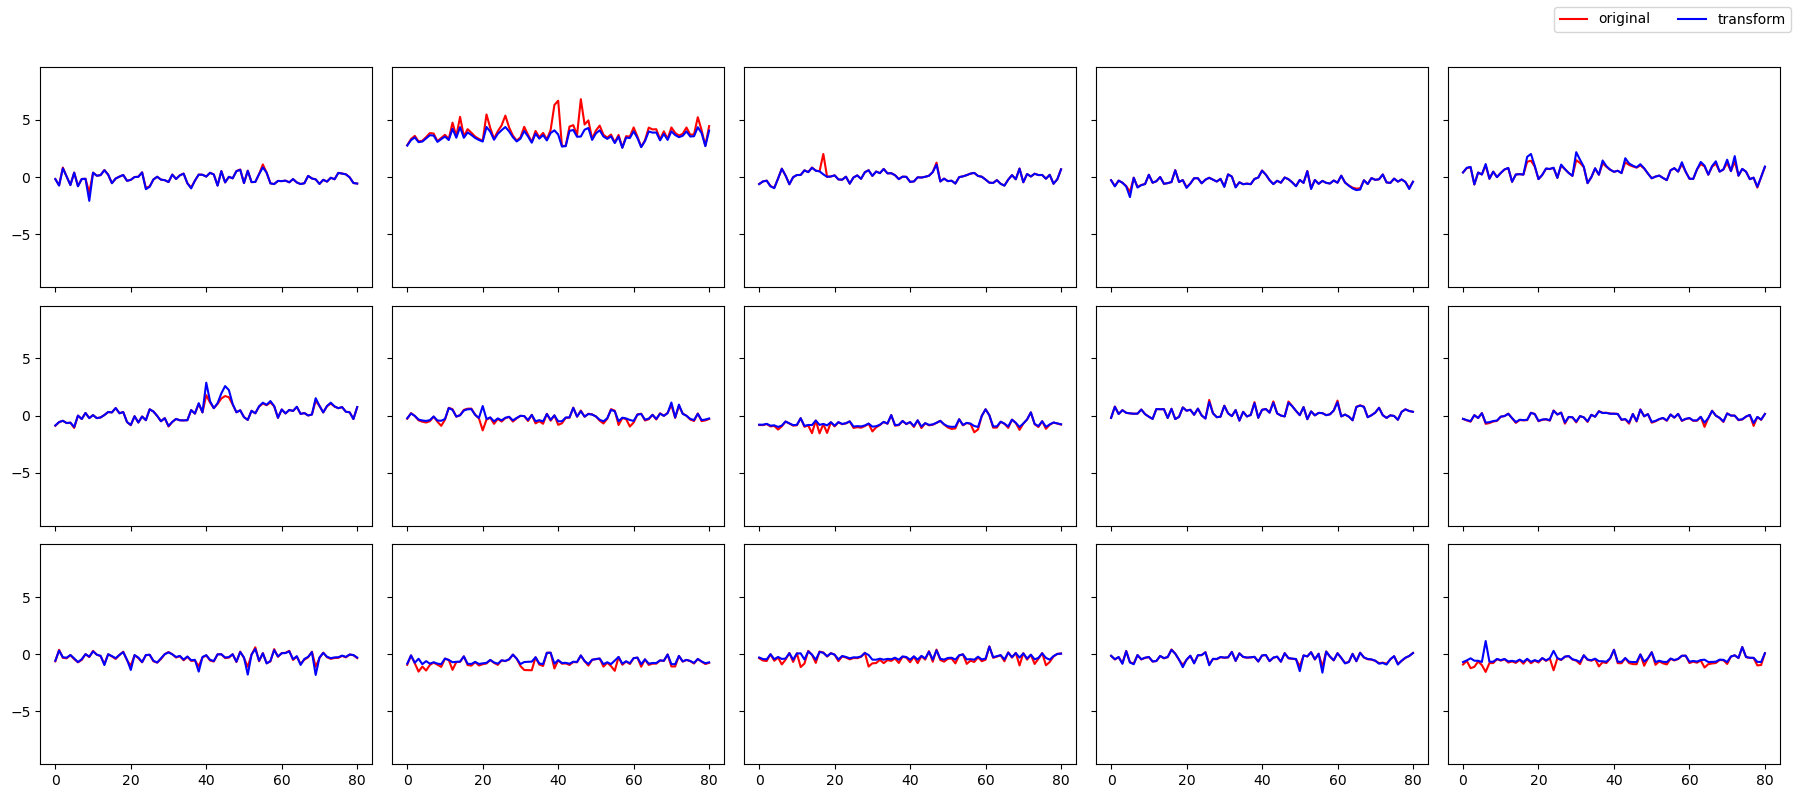

In [9]:
n_sample = 15
nlin = scaled.shape[1]
ncol = scaled.shape[2]
fig, axs = plt.subplots(3, 5, figsize=(18, 8), sharex=True, sharey=True)

lin = random.sample(range(1, nlin), n_sample)
col = random.sample(range(1, ncol), n_sample)

for i, j, ax in zip(lin, col, axs.ravel()):
    
    test = scaled[:, i, j].reshape((-1, 1))
    
    xdata = np.concatenate((test, np.abs(test)**5), axis=1)
    envelope = spenv.specenv(xdata)
    
    b = envelope[envelope[:, 1] == max(envelope[:, 1]), 2:]
    opt = np.sum(xdata*b, axis=1)
    
    ax.plot(test, color="r")
    ax.plot(opt, color='b')
    ax.set_ylim(-np.max(scaled), np.max(scaled))

fig.tight_layout()
fig.legend(labels=['original', 'transform'], ncol=2, loc='upper right')
fig.subplots_adjust(top=0.92)

Below is the smoothing of each time series in the data cube. This is the slowest procedure currently written and can take up to approximately two hours, mostly due to the limitations of the current implementation of `spenv`.

In [29]:
optimal = np.ndarray(scaled.shape)
size = optimal.shape[1] * optimal.shape[2]
counter = 0

start = time.time()
for i in range(0, optimal.shape[1]):
    for j in range(0, optimal.shape[2]):
        counter += 1
        aux = scaled[:, i, j].reshape((-1, 1))
        optimal[:, i, j] = spenv.spec_opt(aux, lambda t: np.abs(t)**5)
        print(str(counter) + "/" + str(size), end="\r")

end = time.time()
print("Time: " + str(end-start))

Time: 28709.571454524994


In [31]:
optimal.shape == scaled.shape

True

The images are saved along with the original rasters.

In [39]:
src = rasterio.open("testing/raster_1.tif")

In [66]:
start_process = time.time()

for i in range(optimal.shape[0]):
    file = "testing/optimal_" + str(i + 1) + ".tif"
    start = time.time()
    with rasterio.open(
        file, 
        'w', 
        driver='GTiff', 
        height=optimal.shape[1], 
        width=optimal.shape[2], 
        count=1, 
        dtype=optimal.dtype,
        crs=src.profile['crs'],
        transform=src.profile['transform']
    ) as dst:
        dst.write(optimal[i], 1)
    end = time.time()
    print("Raster " + str(i) + " time: " + str(round(end-start, 2)))

end_process = time.time()
print("Raster saved in " + str(round(end_process-start_process, 2)) + " seconds")

Raster 0 time: 0.11
Raster 1 time: 0.02
Raster 2 time: 0.11
Raster 3 time: 0.04
Raster 4 time: 0.03
Raster 5 time: 0.05
Raster 6 time: 0.02
Raster 7 time: 0.03
Raster 8 time: 0.05
Raster 9 time: 0.04
Raster 10 time: 0.04
Raster 11 time: 0.21
Raster 12 time: 0.25
Raster 13 time: 0.21
Raster 14 time: 0.33
Raster 15 time: 0.46
Raster 16 time: 0.27
Raster 17 time: 0.64
Raster 18 time: 0.3
Raster 19 time: 0.3
Raster 20 time: 0.5
Raster 21 time: 1.15
Raster 22 time: 0.23
Raster 23 time: 0.25
Raster 24 time: 0.2
Raster 25 time: 0.56
Raster 26 time: 0.12
Raster 27 time: 0.92
Raster 28 time: 0.56
Raster 29 time: 0.31
Raster 30 time: 0.11
Raster 31 time: 0.92
Raster 32 time: 0.4
Raster 33 time: 0.19
Raster 34 time: 0.74
Raster 35 time: 0.45
Raster 36 time: 0.21
Raster 37 time: 0.17
Raster 38 time: 0.33
Raster 39 time: 0.13
Raster 40 time: 1.15
Raster 41 time: 0.2
Raster 42 time: 0.18
Raster 43 time: 0.45
Raster 44 time: 0.24
Raster 45 time: 0.07
Raster 46 time: 0.17
Raster 47 time: 0.55
Raster 4

## Energy Correlation Screening (ECS)
The CD method will be applied using the original and filtered collections of images. If the image data is already present locally, the previous sections can be skipped right up to this point.

In [2]:
directory = 'testing'
files = [directory + "/" + f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f)) and f.startswith('optimal')]

def extract_number(s):
    match = re.search(r'\d+', s)
    return int(match.group()) if match else float('inf')

sorted_files = sorted(files, key=extract_number)

Y = []
for n, i in enumerate(sorted_files):
    temp = rasterio.open(i)
    Y.append(temp.read())
    temp.close()
    print(str(n+1)+"/"+str(len(sorted_files))+": "+sorted_files[n], end="\r")

Y = np.concatenate(Y)

In [3]:
directory = 'testing'
files = [directory + "/" + f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f)) and f.startswith('raster')]

def extract_number(s):
    match = re.search(r'\d+', s)
    return int(match.group()) if match else float('inf')

sorted_files = sorted(files, key=extract_number)

X = []
for n, i in enumerate(sorted_files):
    temp = rasterio.open(i)
    X.append(temp.read())
    temp.close()
    print(str(n+1)+"/"+str(len(sorted_files))+": "+sorted_files[n], end="\r")

X = np.concatenate(X)

In [4]:
del temp

In [5]:
std = np.std(X)
mean = np.mean(X)
Y_ = (Y * std) + mean

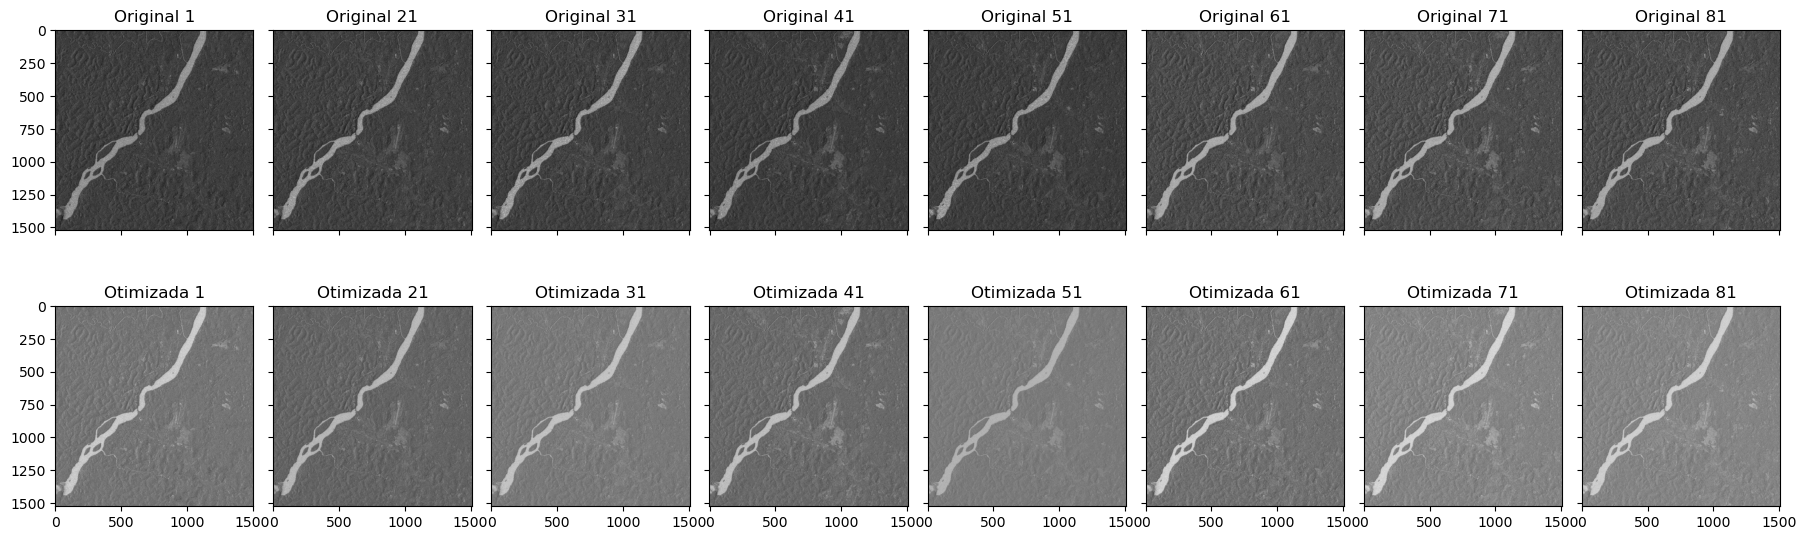

In [6]:
examples = [1, 21, 31, 41, 51, 61, 71, 81]
imagens = ["Original", "Otimizada"]
plots = [(x, y) for x in imagens for y in examples]

fig, axs = plt.subplots(2, 8, figsize=(18, 6), sharex=True, sharey=True)

for plot, ax in zip(plots, axs.ravel()):
    ax.set_title(plot[0] + " " + str(plot[1]))
    if plot[0] == "Original":
        ax.imshow(X[plot[1] - 1], cmap="gray")
    elif plot[0] == "Otimizada":
        ax.imshow(Y_[plot[1] - 1], cmap="gray")

fig.tight_layout()

In [7]:
mean = np.mean(X)
std = np.std(X)
scaled = (X - mean) / std

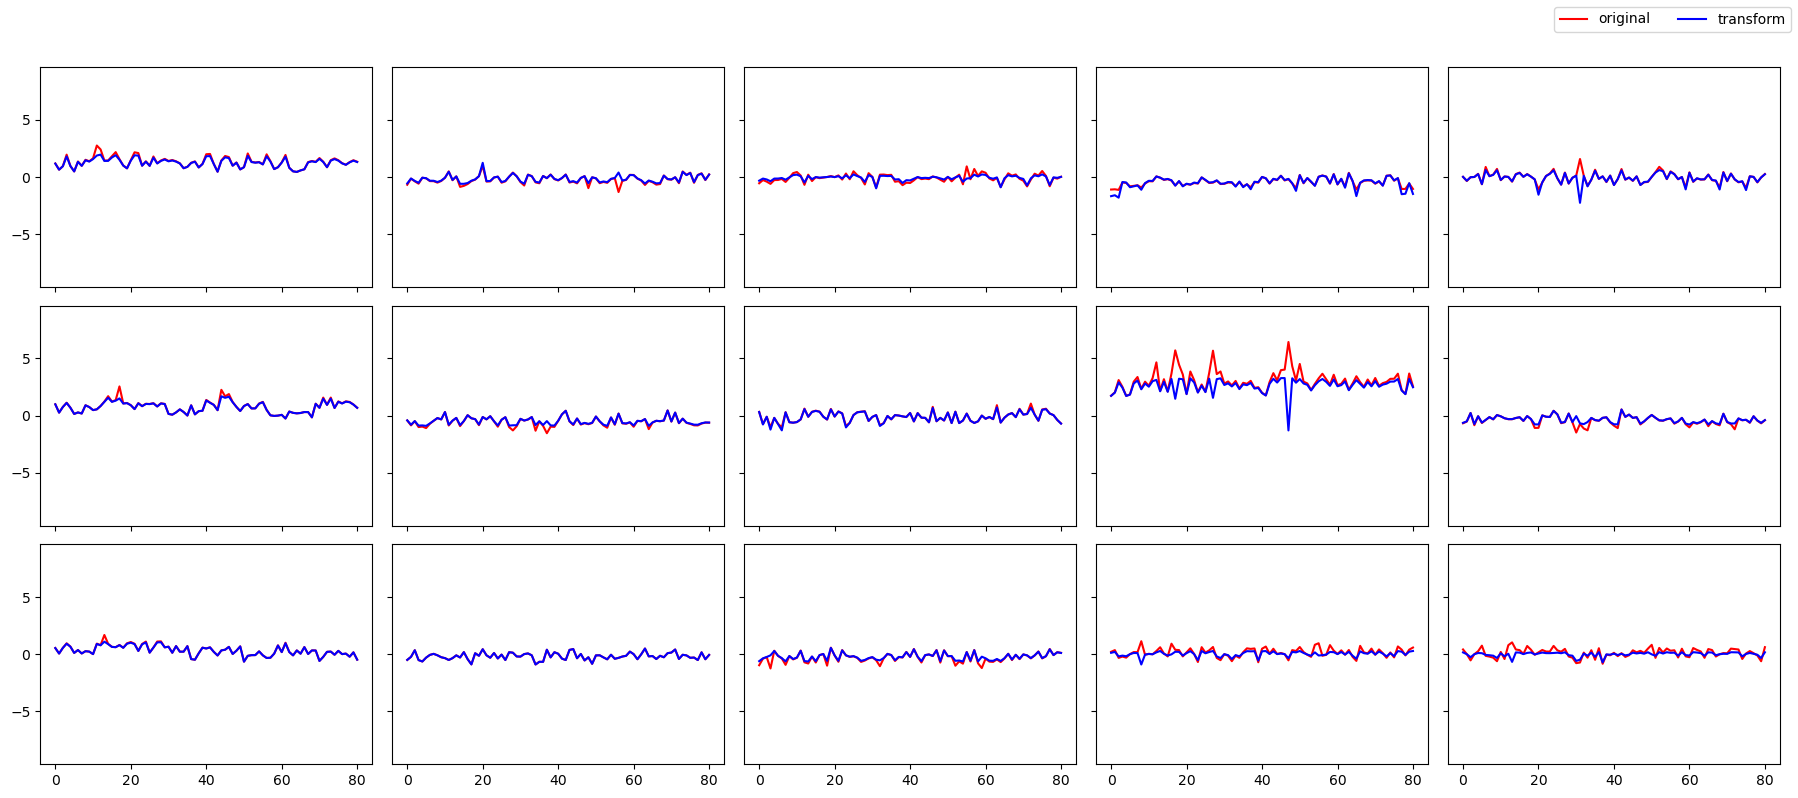

In [8]:
n_sample = 15
nlin = scaled.shape[1]
ncol = scaled.shape[2]
fig, axs = plt.subplots(3, 5, figsize=(18, 8), sharex=True, sharey=True)

lin = random.sample(range(1, nlin), n_sample)
col = random.sample(range(1, ncol), n_sample)

for i, j, ax in zip(lin, col, axs.ravel()):
    
    test = scaled[:, i, j].reshape((-1, 1))
    
    xdata = np.concatenate((test, np.abs(test)**5), axis=1)
    envelope = spenv.specenv(xdata)
    
    b = envelope[envelope[:, 1] == max(envelope[:, 1]), 2:]
    opt = np.sum(xdata*b, axis=1)
    
    ax.plot(test, color="r")
    ax.plot(opt, color='b')
    ax.set_ylim(-np.max(scaled), np.max(scaled))

fig.tight_layout()
fig.legend(labels=['original', 'transform'], ncol=2, loc='upper right')
fig.subplots_adjust(top=0.92)

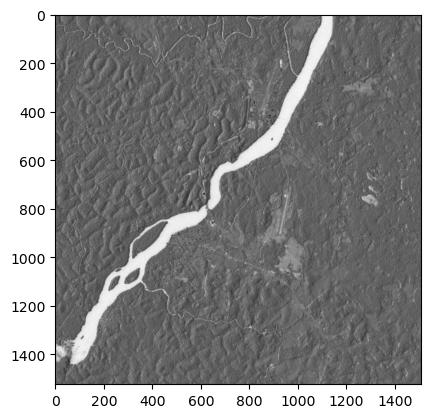

In [9]:
Xm = X.mean(axis=0)
plt.imshow(Xm, cmap="gray")
plt.show()

In [10]:
D = np.ndarray(X.shape)

for i in range(0, X.shape[0]):
    start = time.time()
    D[i] = (Y_[i] - Xm)**2
    end = time.time()
    print(str(i+1)+"/"+str(X.shape[0])+" in "+str(round(end-start, 2))+"s", end="\r")

D.shape

(81, 1524, 1507)

In [11]:
d = D.sum(axis=(1, 2)).ravel()

In [12]:
R = np.ndarray(Xm.shape)
total = X.shape[1] * X.shape[2]

for i in range(0, X.shape[1]):
    for j in range(0, X.shape[2]):
        R[i, j] = np.abs(np.corrcoef(d, D[:, i, j])[0][1])

R.shape

(1524, 1507)

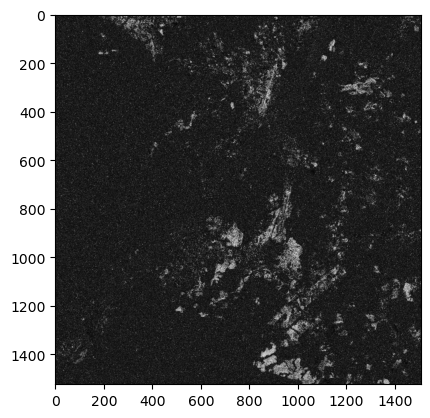

In [13]:
plt.imshow(R, cmap="gray")
plt.show()

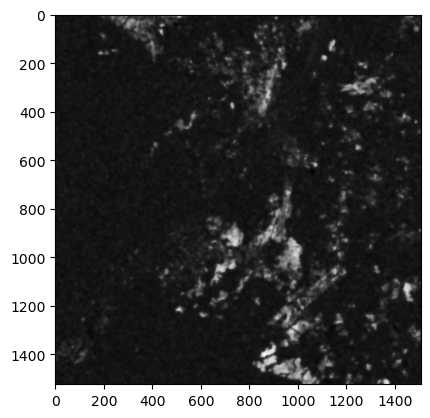

In [14]:
Rd = denoise_tv_chambolle(R, weight=0.5)
plt.imshow(Rd, cmap="gray")
plt.show()

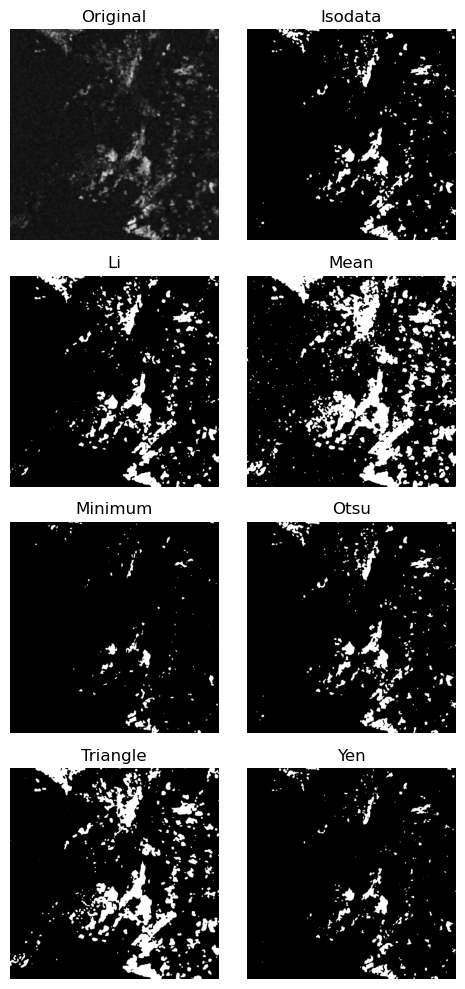

In [15]:
try_all_threshold(Rd, figsize=(5, 10), verbose=False)
plt.show()

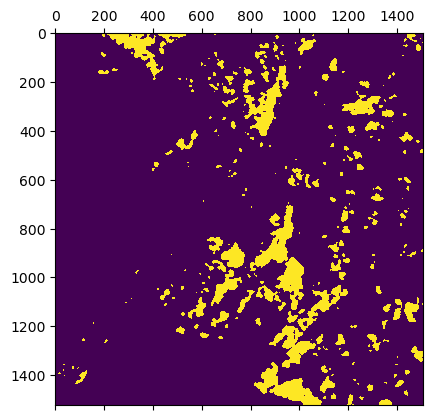

In [16]:
threshold = threshold_li(Rd)
binary = Rd > threshold
binary = binary.astype(int)

plt.matshow(binary)
plt.show()

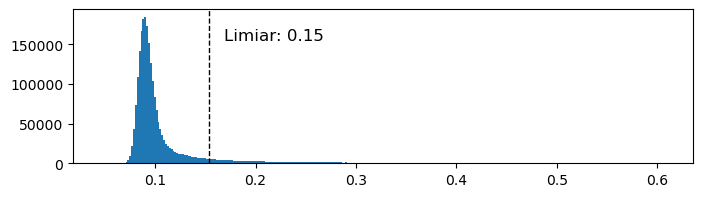

In [67]:
plt.figure(figsize=(8,2))
plt.hist(Rd.ravel(), bins=300)
plt.axvline(threshold, color='k', linestyle='dashed', linewidth=1)
min_ylim, max_ylim = plt.ylim()
plt.text(threshold*1.1, max_ylim*0.8, 'Limiar: {:.2f}'.format(threshold), fontsize=12)
plt.savefig("assets/hist.png", dpi=300)

In [18]:
temp = rasterio.open("testing/raster_1.tif")
temp

<open DatasetReader name='testing/raster_1.tif' mode='r'>

In [19]:
with rasterio.open(
    'assets/binary.tif',
    'w',
    driver='GTiff',
    height=binary.shape[0],
    width=binary.shape[1],
    count=1,
    dtype=binary.dtype,
    crs='+proj=latlong',
    transform=temp.transform,
) as dst:
    dst.write(binary, 1)

temp.close()
del temp

In [20]:
change = gpd.read_file("shp/Change.shp")
nonchange = gpd.read_file("shp/NonChange.shp")
res = rasterio.open("assets/binary.tif")

In [21]:
change_mask, _ = mask(res, change.geometry, crop=True, nodata=99999.0)
nonchange_mask, _ = mask(res, nonchange.geometry, crop=True, nodata=99999.0)
res.close()
del res

In [22]:
true_positive = (change_mask == 1).sum()
false_negative = (change_mask == 0).sum()

false_positive = (nonchange_mask == 1).sum()
true_negative = (nonchange_mask == 0).sum()

In [23]:
precision = true_positive/(true_positive + false_positive)
precision

0.9976926085256159

In [24]:
recall = true_positive/(true_positive + false_negative)
recall

0.7254106518298058

In [25]:
f1 = 2 * (precision*recall)/(precision + recall)
f1

0.8400388556250102

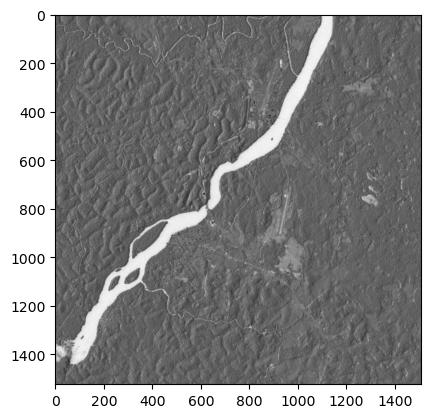

In [26]:
plt.imshow(Xm, cmap="gray")

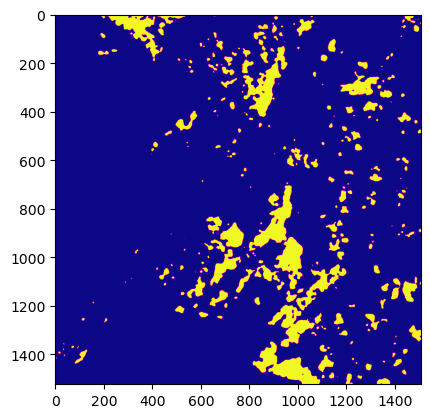

In [27]:
plt.imshow(binary, cmap="plasma")

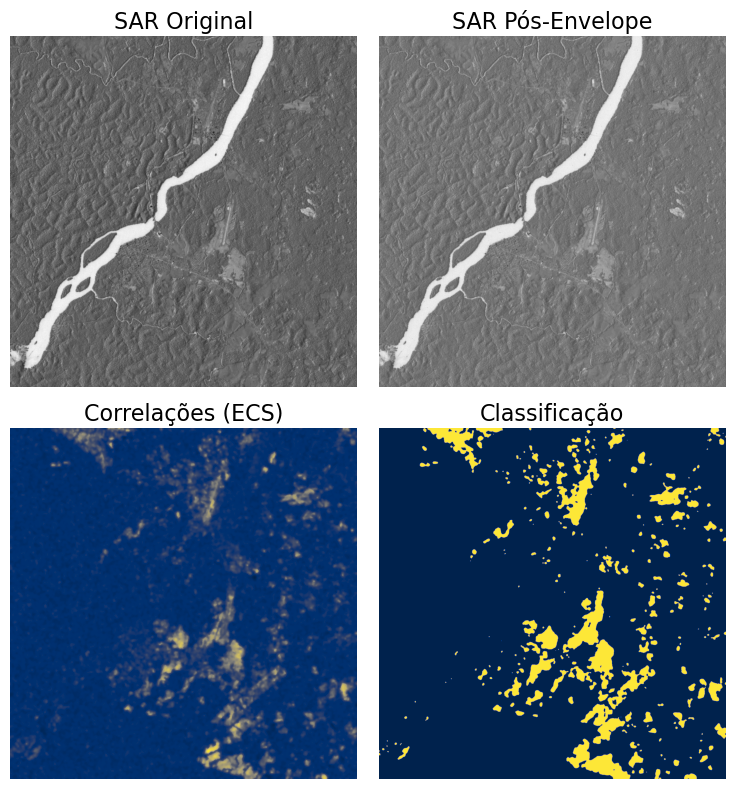

In [28]:
palette = "gray"
fsize = 16
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(8, 8), tight_layout=True)

axs[0, 0].imshow(Xm, cmap=palette)
axs[0, 0].set_title("SAR Original", fontsize=fsize)
axs[0, 0].axis("off")

axs[0, 1].imshow(Y_.mean(axis=0), cmap=palette)
axs[0, 1].set_title("SAR Pós-Envelope", fontsize=fsize)
axs[0, 1].axis("off")

axs[1, 0].imshow(Rd, cmap="cividis")
axs[1, 0].set_title("Correlações (ECS)", fontsize=fsize)
axs[1, 0].axis("off")

axs[1, 1].imshow(binary, cmap="cividis")
axs[1, 1].set_title("Classificação", fontsize=fsize)
axs[1, 1].axis("off")

fig.savefig("assets/classes.png", dpi=180)

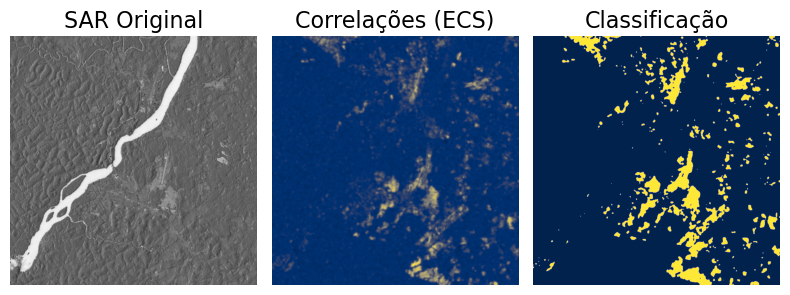

In [32]:
palette = "gray"
fsize = 16
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(8, 8), tight_layout=True)

axs[0].imshow(Xm, cmap=palette)
axs[0].set_title("SAR Original", fontsize=fsize)
axs[0].axis("off")

axs[1].imshow(Rd, cmap="cividis")
axs[1].set_title("Correlações (ECS)", fontsize=fsize)
axs[1].axis("off")

axs[2].imshow(binary, cmap="cividis")
axs[2].set_title("Classificação", fontsize=fsize)
axs[2].axis("off")

fig.savefig("assets/classes2.png", dpi=180)

In [38]:
shape = ee.FeatureCollection(geom)

In [40]:
task = ee.batch.Export.table.toDrive(
    collection=shape, description='brazil-guyana', fileFormat='SHP'
)
task.start()

In [43]:
task.status()

{'state': 'COMPLETED',
 'description': 'brazil-guyana',
 'priority': 100,
 'creation_timestamp_ms': 1725321725248,
 'update_timestamp_ms': 1725321735710,
 'start_timestamp_ms': 1725321728474,
 'task_type': 'EXPORT_FEATURES',
 'destination_uris': ['https://drive.google.com/'],
 'attempt': 1,
 'batch_eecu_usage_seconds': 0.00042547399061731994,
 'id': '3REWYGA2TL4NVINQHQMTGDLT',
 'name': 'projects/earthengine-legacy/operations/3REWYGA2TL4NVINQHQMTGDLT'}